## Convolutional Neural Network (CNN) 

In [37]:
# Importing Libraries

import numpy as np
import glob
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
tumor_yes = []
path = '/Users/abhadra/Downloads/Brain_tumor_ds/brain_tumor_dataset/yes/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img,(128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor_yes.append(img)

len(tumor_yes)

86

In [39]:
# tumor_yes.shape  # 128rows x 128cols x 3 channels(RBG)

# 86 images with dimensions 128 x 128 x 3 channels(RBG)

In [40]:
tumor_no = []
path = '/Users/abhadra/Downloads/Brain_tumor_ds/brain_tumor_dataset/no/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img,(128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor_no.append(img)

len(tumor_no)

85

In [41]:
# combining 'Yes' and 'No' datasets into one

tumor_yes = np.array(tumor_yes)
tumor_no = np.array(tumor_no)
all_img = np.concatenate((tumor_yes, tumor_no))
all_img.shape

(171, 128, 128, 3)

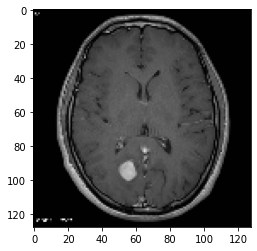

In [42]:
plt.imshow(tumor_yes[0])
plt.show()

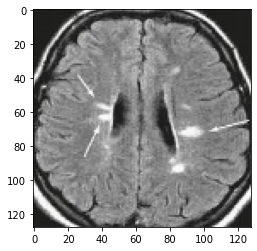

In [43]:
plt.imshow(tumor_no[0])
plt.show()

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Class

In [45]:
# Train-test Split

from sklearn.model_selection import train_test_split 

In [46]:
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
    
    def __add__(self, other):
        return ConcatDataset([self,other])  

In [47]:
class MRI(Dataset):
    
    def __init__(self):        # __init__ is a constructor
    
    # getting images
        tumor_yes = []
        path = '/Users/abhadra/Downloads/Brain_tumor_ds/brain_tumor_dataset/yes/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img,(128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape(img.shape[2], img.shape[0], img.shape[1])
            tumor_yes.append(img)

        tumor_no = []
        path = '/Users/abhadra/Downloads/Brain_tumor_ds/brain_tumor_dataset/no/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img,(128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape(img.shape[2], img.shape[0], img.shape[1])
            tumor_no.append(img)  

        tumor_yes = np.array(tumor_yes, dtype = np.float32)
        tumor_no = np.array(tumor_no, dtype = np.float32)   
     
        # getting labels
        tumor_yes_label = np.ones(tumor_yes.shape[0], dtype = np.float32)
        tumor_no_label = np.zeros(tumor_no.shape[0], dtype = np.float32)
        
        # concatenate the no_tumor and yes_tumor images
        self.images = np.concatenate((tumor_yes, tumor_no), axis=0)
        self.labels = np.concatenate((tumor_yes_label, tumor_no_label), axis=0)
    
    
    def __len__(self):
        return self.images.shape[0]           # gives len of images 
    
    def __getitem__(self, index):
        sample = {'image':self.images[index], 'label':self.labels[index]}
        return sample
    
    def normalize(self):
        self.images = self.images/255         # values between zero and one

In [48]:
mri = MRI()
mri.normalize()

### DataLoader

In [49]:
from torch.utils.data import Dataset, DataLoader

In [50]:
dataloader = DataLoader(mri, batch_size=32, shuffle=True)

### CNN Model

In [51]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        
         ## 1st layer
        self.cnn_model = nn.Sequential(
                         nn.Conv2d(in_channels=3,         # RGB
                                   out_channels=6,         # no_of_filters
                                   kernel_size=5),       # matrix_size
                          nn.Tanh(),              # activation_function (crushed betweeen -1 and 1)
                          nn.AvgPool2d(kernel_size=2, stride=5),
                                
                               ## 2nd layer (more precise)
                          nn.Conv2d(in_channels=6,           # RGB
                                    out_channels=16,                   # no_of_filters
                                    kernel_size=5),                 # matrix_size
                          nn.Tanh(),                          # activation_function (crushed betweeen -1 and 1)
                          nn.AvgPool2d(kernel_size=2, stride=5)) 
                               
        ## fully connected linear layer
        self.fc_layer = nn.Sequential(
                        nn.Linear(in_features=256 ,out_features=120),     #256 = 4 x 4 x 16
                        nn.Tanh(),
                        nn.Linear(in_features=120 ,out_features=84),
                        nn.Tanh(),
                        nn.Linear(in_features=84 ,out_features=1))         # need only 1 neuron(Binary: yes or no
                               
        ## forward pass (will pass input data through all the above layers)
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        x = F.sigmoid(x)        
        return x       

In [52]:
model = CNN_Model().to(device)

### Model Training

In [53]:
import torch.optim as optim

In [54]:
learning_rate = 0.001
epochs = 200

In [55]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
model.train()

CNN_Model(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [57]:
for epoch in range(epochs):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()             # to cleear the cache
        # put data to gpu
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))     #squeeze makes dim of y_hat and labeel same
        # backward propogation
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    if (epoch+1) % 20==0:
        print('Train_epoch: {}\loss: {:6f}'.format(epoch+1, np.mean(losses)))

Train_epoch: 20\loss: 0.208041
Train_epoch: 40\loss: 0.005346
Train_epoch: 60\loss: 0.000951
Train_epoch: 80\loss: 0.000508
Train_epoch: 100\loss: 0.000349
Train_epoch: 120\loss: 0.000204
Train_epoch: 140\loss: 0.000152
Train_epoch: 160\loss: 0.000123
Train_epoch: 180\loss: 0.000096
Train_epoch: 200\loss: 0.000078


### Model Evaluation

In [58]:
# defining threshold

def threshold(scores, threshold=0.50, minimum=0.0, maximum=1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x <= threshold] = minimum
    return x

In [59]:
# Actual v/s Predicted values

model.eval()
outputs = []
y_true = []

with torch.no_grad():
    
    for D in dataloader:
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [61]:
## Accuracy score

accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Yes_tumor'), Text(0, 1.5, 'Healthy')]

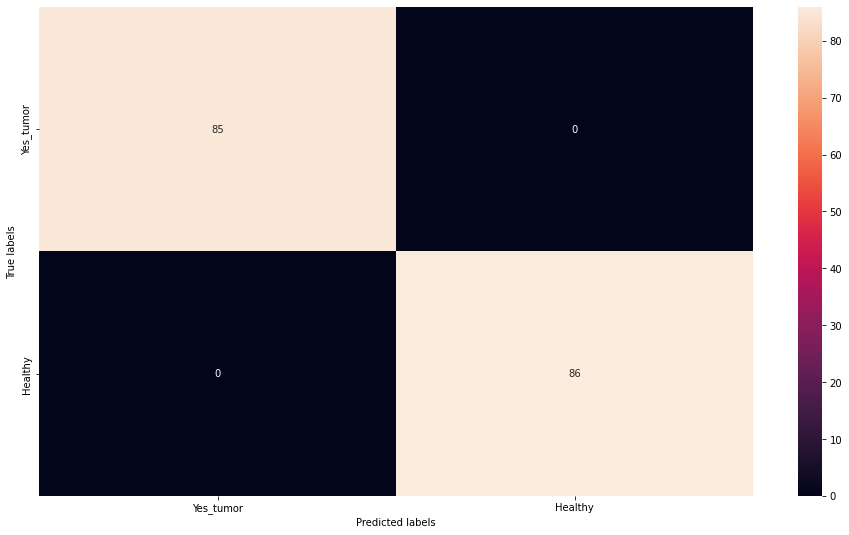

In [62]:
# Confusion Matrix

cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)      

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Yes_tumor', 'Healthy'])
ax.yaxis.set_ticklabels(['Yes_tumor', 'Healthy'])

### Let's Try ANN

In [89]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()       ## reshaping 2D images to 1D for ANN
        self.linear_relu_stack = nn.Sequential(
                                 nn.Linear(49152, 20000),
                                 nn.ReLU(),
                                 nn.Linear(20000, 5000),
                                 nn.ReLU(),
                                 nn.Linear(5000, 1000),
                                 nn.ReLU(),
                                 nn.Linear(1000, 500),
                                 nn.ReLU(),
                                 nn.Linear(500, 1))
            
   # def forward(self, x):
    #    x = self.flatten(x)
     #   logits = self.linear_relu_stack(x)
      #  softmax = nn.Softmax(dim=1)
       # pred_probab = softmax(logits)
        #return pred_probab
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = x.view(x.size(0), -1)
        x = F.sigmoid(x)        
        return x      

In [90]:
ann_model = ANN().to(device)

In [92]:
lr = 0.01
n_iter = 10

In [93]:
loss_fn = torch.nn.CrossEntropyLoss()
ann_optim = optim.SGD(ann_model.parameters(), lr=lr)

In [94]:
ann_model.train()

ANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=49152, out_features=20000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20000, out_features=5000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5000, out_features=1000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=500, bias=True)
    (7): ReLU()
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [95]:
for i in range (n_iter):
    loss_val = []
    
    for d in dataloader:
        optimizer.zero_grad()             # to cleear the cache
        # put data to gpu
        data = d['image'].to(device)
        label = d['label'].to(device)
        y_hat_ann = ann_model(data)
        loss = torch.sum(loss_fn(y_hat_ann.squeeze(), label))     #squeeze makes dim of y_hat and label same
        # backward propogation
        loss.backward()
        optimizer.step()
        loss_val.append(loss.item())
    
    if (i+1) % 2==0:
        print('Train_iters: {}\loss: {:6f}'.format(i+1, np.mean(loss_val)))
        

Train_iters: 2\loss: 48.963287
Train_iters: 4\loss: 48.429392
Train_iters: 6\loss: 49.141158
Train_iters: 8\loss: 48.607289
Train_iters: 10\loss: 48.251388
